In [ ]:
%pip install sqlalchemy

In [15]:
# Import Libraries
import pg8000
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
# Fetch Data from Postrgres
conn = pg8000.connect(
    host="localhost", 
    database="ChinaCrimeAnalysis",  
    user="postgres",  
    password="Kaviya@190601",  
    port="5432"
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM crime_data")

rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
crime_data = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()

crime_data.head()

,crime_id,crime_type,location,date,time,victim_age,suspect_age,weapon_used,latitude,longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00:00,63,30,Unknown,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01:00,47,59,Unknown,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02:00,57,20,Unknown,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04:00,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05:00,68,29,None,23.120373,116.131223


In [17]:
# Data Cleaning
crime_data.ffill(inplace = True)
crime_data['date'] = pd.to_datetime(crime_data['date'], errors = 'coerce')
crime_data.dropna(subset=['date'], inplace = True)
crime_data.drop_duplicates(inplace = True)
crime_data['crime_type'] = crime_data['crime_type'].str.title()

In [18]:
# Feature Extraction
crime_data['year'] = crime_data['date'].dt.year
crime_data['month'] = crime_data['date'].dt.month
crime_data['day'] = crime_data['date'].dt.day
crime_data['day_of_week'] = crime_data['date'].dt.dayofweek
crime_data['Hour'] = crime_data['date'].dt.hour

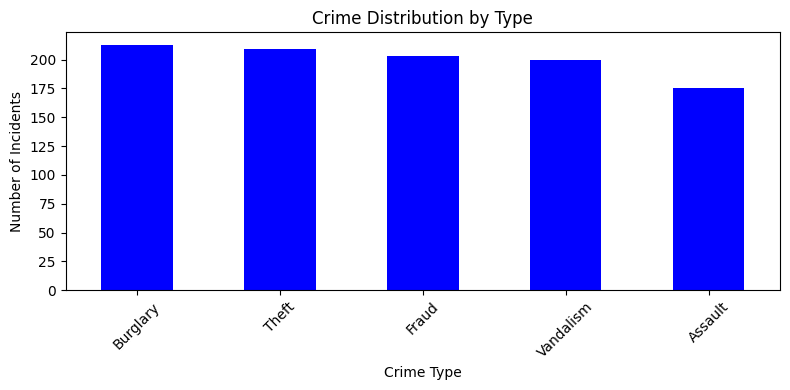

In [19]:
# Crime Distribution by Type
plt.figure(figsize = (8, 4))
crime_counts = crime_data['crime_type'].value_counts()
crime_counts.plot(kind = 'bar', color = 'blue')
plt.title('Crime Distribution by Type')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

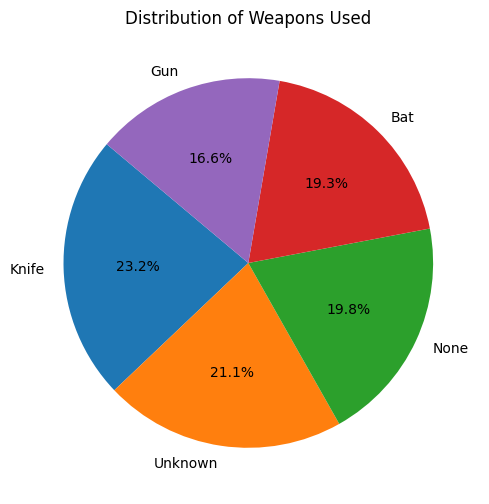

In [20]:
# Weapon Used Distribution
weapon_counts = crime_data['weapon_used'].value_counts()
plt.figure(figsize = (6, 6))
plt.pie(weapon_counts, labels=weapon_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Weapons Used')
plt.show()

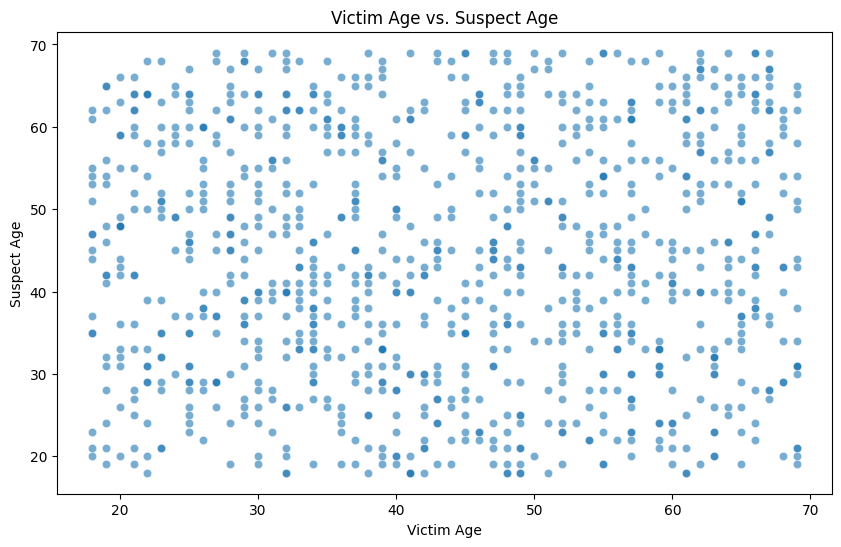

In [21]:
# Age Analysis
plt.figure(figsize = (10, 6))
sns.scatterplot(data = crime_data, x ='victim_age', y ='suspect_age', alpha = 0.6)
plt.title('Victim Age vs. Suspect Age')
plt.xlabel('Victim Age')
plt.ylabel('Suspect Age')
plt.show()

In [22]:
# Predictive Modeling with Random Forest
X = crime_data[['latitude', 'longitude', 'victim_age']] 
y = crime_data['crime_type'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

     Assault       0.21      0.16      0.18        37
    Burglary       0.20      0.24      0.22        41
       Fraud       0.20      0.19      0.19        43
       Theft       0.24      0.22      0.23        45
   Vandalism       0.16      0.18      0.17        34

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.20       200
weighted avg       0.20      0.20      0.20       200

[[ 6  8  9  5  9]
 [ 8 10  7  8  8]
 [ 2 12  8 12  9]
 [ 7 11 11 10  6]
 [ 6 10  6  6  6]]


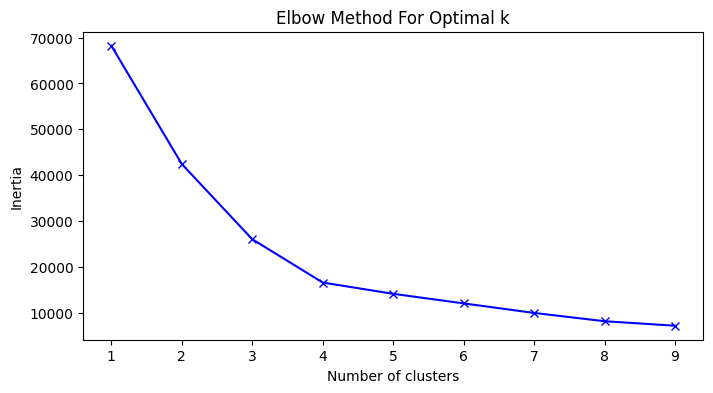

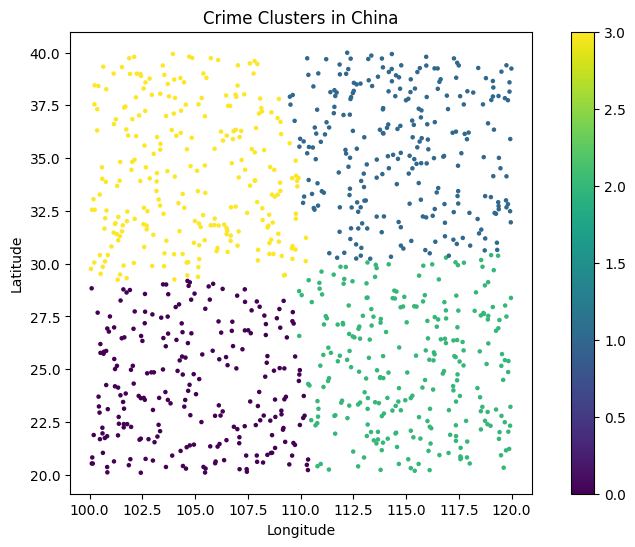

In [23]:
# Clustering with K-Means
if 'latitude' in crime_data.columns and 'longitude' in crime_data.columns:
    X = crime_data[['latitude', 'longitude']].dropna()
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state = 42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    crime_data['Cluster'] = kmeans.fit_predict(X)

    gdf = gpd.GeoDataFrame(crime_data, geometry = gpd.points_from_xy(crime_data.longitude, crime_data.latitude))
    gdf.plot(column='Cluster', cmap='viridis', markersize=5, figsize = (10, 6), legend=True)
    plt.title('Crime Clusters in China')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("Dataset does not contain 'Latitude' and 'Longitude' columns.")
